The lower limit of $T^{0\nu\beta\beta}_{1/2}$ is given by
$$ T^{0\nu\beta\beta}_{1/2}|_{\text{low}}  = \text{log}(2) t \frac{\epsilon_s}{\alpha(\text{C.L.})\sqrt{b}} N_0$$


The sensitivity of a $0\nu\beta\beta$ experiment is proportional to the value
$$\text{figure of merit} = \frac{\epsilon_s}{\sqrt{\epsilon_b}}$$
were $\epsilon_{s, b}$ are the selection efficiencies for signal and background after the selection cuts.

If no cuts are applied, the figure of merit is 1, therefore any cut that improves sensitivity must fullfil
$$\frac{\epsilon_s}{\sqrt{\epsilon_b}} > 1 $$

In [1]:
import os
import sys
import time
import glob
import pandas as pd
import numpy  as np

from itertools import combinations

from invisible_cities.core.system_of_units import kg, dalton, year, mBq
from invisible_cities.evm.mixer            import get_file_number

from invisible_cities.io.dst_io            import load_dst, load_dsts
from invisible_cities.database.load_db     import RadioactivityData

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["figure.max_open_warning"] = False

In [23]:
get_isotope_name  = lambda name: name.split("/")[-5]
get_g4volume_name = lambda name: name.split("/")[-4] 

def load_tracks_with_info(filenames):
    
    tracks = pd.DataFrame()
    for f, filename in enumerate(filenames, 1):
        
        print(f"Processed {f} / {len(filenames)}", end="\r")
        
        try:
            tracks_ = pd.read_hdf(filename, f"Tracking/Tracks").set_index("event")
        except:
            continue
        # energy cut
        energies = tracks_.groupby(level=0).energy.sum()
        sel = (2.40 <= energies) & (energies <= 2.55)
        tracks_ = tracks_.loc[sel].reset_index()
        tracks_["G4Volume"] = get_g4volume_name(filename)
        tracks_["file"]     = get_file_number(filename)

        tracks = pd.concat([tracks, tracks_])
        
    return tracks


def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    if not sel_spurious.any(): return tracks
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks

In [3]:
act_df, mceff_df = RadioactivityData("next100")
eff_df = pd.read_csv("efficiencies_ic.csv")

index = ["G4Volume", "Isotope"]
eff_df   =  eff_df.set_index(index)
act_df   =  act_df.set_index(index)
mceff_df = mceff_df.set_index(index)

eff_df["exposure"] = ((eff_df.nsim/(mceff_df.MCEfficiency*act_df.TotalActivity * mBq))/year)

In [4]:
exposure   = 100.
enrichment = 0.9
xenon_mass = 100. * kg
N0 = enrichment*(xenon_mass/(136. * dalton))

T12_0nubb = (N0 * np.log(2) * exposure) / eff_df.loc[("ACTIVE", "0nubb")].nsim

print("simulated 0nubb half-life (years):", T12_0nubb)

simulated 0nubb half-life (years): 1.8415720842306204e+24


In [5]:
path = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

t0 = time.time()
filenames = glob.glob(path.format(isotope="0nubb", g4volume="*"))
tracks_0nubb = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 0.30307747920354206


In [6]:
t0 = time.time()
filenames = glob.glob(path.format(isotope="214Bi", g4volume="*"))
tracks_214Bi = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 3.808922517299652


In [7]:
t0 = time.time()
filenames = glob.glob(path.format(isotope="208Tl", g4volume="*"))
tracks_208Tl = load_tracks_with_info(filenames).set_index(["event", "file"])
print("Time:", (time.time()-t0) / 60)

Time: 19.22451733350754


In [33]:
spurious_energy = 0.01

# remove spurious
tracks_0nubb = remove_spurious_tracks(tracks_0nubb, spurious_energy)
tracks_214Bi = remove_spurious_tracks(tracks_214Bi, spurious_energy)
tracks_208Tl = remove_spurious_tracks(tracks_208Tl, spurious_energy)

In [34]:
Ns = tracks_0nubb.index.nunique()
Nb = tracks_214Bi.index.nunique() + tracks_208Tl.index.nunique()

## Track multiplicity

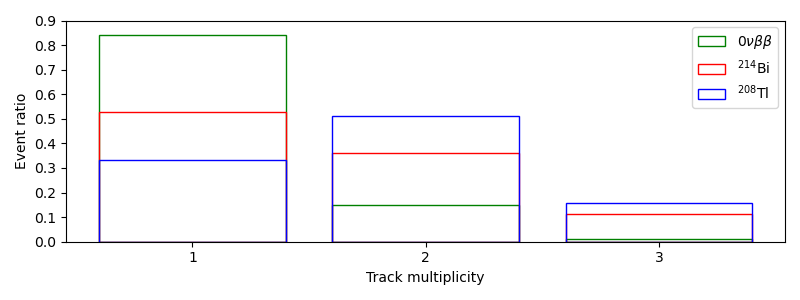

In [37]:
plt.figure(figsize=[8,3])

bins = np.arange(0.5, 4.5, 1)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram(tracks_0nubb.groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$0\nu\beta\beta$", color="none", edgecolor="g")

# background
h, _ = np.histogram(tracks_214Bi.groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$^{214}$Bi", color="none", edgecolor="r")

h, _ = np.histogram(tracks_208Tl.groupby(level=[0,1]).numb_of_tracks.max(), bins=bins)
plt.bar(binc, h/h.sum(), label=r"$^{208}$Tl", color="none", edgecolor="b")

plt.legend()
plt.ylabel("Event ratio")
plt.xlabel("Track multiplicity")
plt.xticks(binc)
plt.yticks(np.arange(0, 1, 0.1))
plt.tight_layout()

In [39]:
# ntracks = 1
n = 1

sel = tracks_0nubb.numb_of_tracks <= n
es = tracks_0nubb.loc[sel].index.size / Ns

npass  = 0
# 214Bi
sel = tracks_214Bi.numb_of_tracks <= n
npass += tracks_214Bi.loc[sel].index.size
# 208Tl
sel = tracks_208Tl.numb_of_tracks <= n
npass += tracks_208Tl.loc[sel].index.size
eb = npass / Nb

print(f"ntracks <= {n} cut: fom =", round(es/np.sqrt(eb), 2))

ntracks <= 1 cut: fom = 1.43


In [40]:
tracks_0nubb = tracks_0nubb.loc[tracks_0nubb.numb_of_tracks == 1]
tracks_214Bi = tracks_214Bi.loc[tracks_214Bi.numb_of_tracks == 1]
tracks_208Tl = tracks_208Tl.loc[tracks_208Tl.numb_of_tracks == 1]

## Fiducialization

Efficiency: 0.9453503746143676


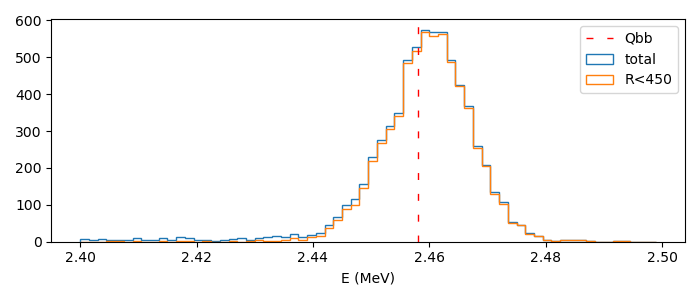

In [41]:
plt.figure(figsize=[7, 3])

tracks = tracks_0nubb

rmax = 450
bins = np.arange(2.40, 2.50, 0.0015)

plt.hist(tracks_0nubb.energy, bins=bins, histtype="step", label="total")

# R cut
sel = (tracks_0nubb.r_max < rmax)
print("Efficiency:", sel.sum()/tracks_0nubb.index.size)
plt.hist( tracks_0nubb.loc[sel].groupby(level=[0,1]).energy.sum()
        , bins=bins, histtype="step", label=f"R<{rmax}")

Qbb = 2.458
plt.axvline(Qbb, c="r", linewidth=1, linestyle=(0, (5, 10)), label="Qbb")

plt.xlabel("E (MeV)")

plt.legend()
plt.tight_layout();

In [42]:
rmax = 450
tracks_0nubb = tracks_0nubb.loc[tracks_0nubb.r_max < rmax]
tracks_214Bi = tracks_214Bi.loc[tracks_214Bi.r_max < rmax]
tracks_208Tl = tracks_208Tl.loc[tracks_208Tl.r_max < rmax]

## ROI and $E_{b_2}$

In [43]:
# no overlap
print("No overlap between blobs efficiencies:")

sel = tracks_0nubb.ovlp_blob_energy >0
print("0nubb:", round(sel.sum()/len(sel), 3))
tracks_0nubb = tracks_0nubb.loc[~sel]

sel = tracks_208Tl.ovlp_blob_energy >0
print("208Tl:", round(sel.sum()/len(sel), 3))
tracks_208Tl = tracks_208Tl.loc[~sel]

sel = tracks_214Bi.ovlp_blob_energy >0
print("214Bi:", round(sel.sum()/len(sel), 3))
tracks_214Bi = tracks_214Bi.loc[~sel]

No overlap between blobs efficiencies:
0nubb: 0.018
208Tl: 0.004
214Bi: 0.004


In [ ]:
# plt.figure(figsize=[7, 3])

# xbins = np.arange(2.41, 2.50, 0.002)
# ybins = np.arange(0, 1.20, 0.02)
# binc = (bins[1:] + bins[:-1])/2.

# plt.hist2d( tracks_0nubb.energy, tracks_0nubb.eblob2, bins=[xbins, ybins]
#           , density=True, label=r"$0\nu\beta\beta$")

# plt.xlabel("Energy (MeV)")
# plt.ylabel(r"E$_{b_2}$ (MeV)")
# plt.tight_layout()

# plt.figure(figsize=[7, 3])

# xbins = np.arange(2.41, 2.50, 0.002)
# ybins = np.arange(0, 1.20, 0.02)
# binc = (bins[1:] + bins[:-1])/2.

# plt.hist2d( tracks_208Tl.energy, tracks_208Tl.eblob2, bins=[xbins, ybins]
#           , density=True, label=r"$0\nu\beta\beta$")

# plt.xlabel("Energy (MeV)")
# plt.ylabel(r"E$_{b_2}$ (MeV)")
# plt.tight_layout()

In [44]:
ROI = np.arange(2.41, 2.50, 0.002)
combs = list(combinations(ROI, 2))

s = []
b = []
for i, comb in enumerate(combs):
    emin, emax = comb
    st  = tracks_0nubb.loc[(emin<=tracks_0nubb.energy) & (tracks_0nubb.energy<emax)]
    bt1 = tracks_208Tl.loc[(emin<=tracks_208Tl.energy) & (tracks_208Tl.energy<emax)]
    bt2 = tracks_214Bi.loc[(emin<=tracks_214Bi.energy) & (tracks_214Bi.energy<emax)]
    s.append( len(st)             /Ns)
    b.append((len(bt1) + len(bt2))/Nb)
s = np.array(s)
b = np.array(b)

roi = combs[np.argmax(s/np.sqrt(b))]

print("f.o.m:", np.max(s/np.sqrt(b)))

f.o.m: 3.3647746289377047


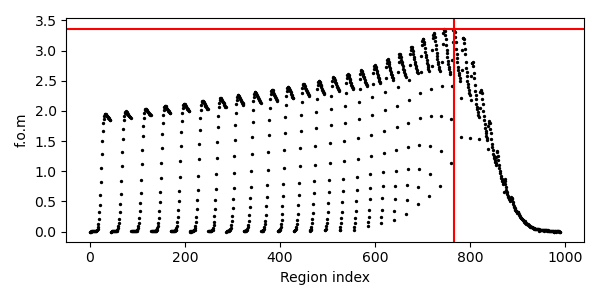

In [45]:
plt.figure(figsize=[6, 3])
plt.scatter(range(len(s)), s/np.sqrt(b), s=2, color="k")

plt.axvline(np.argmax(s/np.sqrt(b)), c="r")
plt.axhline(np.max   (s/np.sqrt(b)), c="r")

plt.xlabel("Region index")
plt.ylabel("f.o.m")
plt.tight_layout();

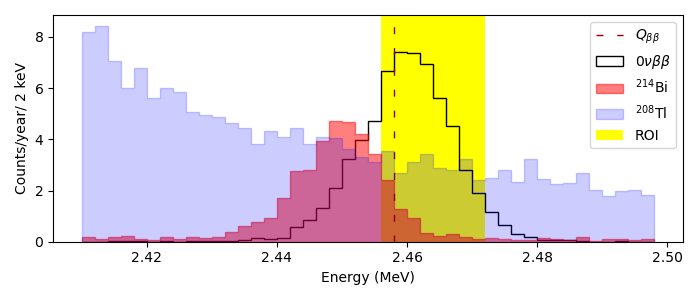

In [46]:
fig = plt.figure(figsize=[7, 3])
ax = fig.add_subplot(111)

bins = np.arange(2.41, 2.50, 0.002)
binc = (bins[1:] + bins[:-1])/2.

# signal
h, _ = np.histogram(tracks_0nubb.energy, bins=bins)
ax.stairs(h/100, bins, label=r"$0\nu\beta\beta$", facecolor="none", edgecolor="k", fill=True)


# 214Bi
df = eff_df.loc[(slice(None), "214Bi"), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()
h, _ = np.histogram(tracks_214Bi.energy, bins=bins)
ax.stairs(h/T, bins, label=r"$^{214}$Bi", facecolor="r", edgecolor="r", alpha=0.5, fill=True)


# 208Tl
df = eff_df.loc[(slice(None), "208Tl"), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()
h, _ = np.histogram(tracks_208Tl.energy, bins=bins)
ax.stairs(h/T, bins, label=r"$^{208}$Tl", facecolor="b", edgecolor="b", alpha=0.2, fill=True)

# ROI
Qbb = 2.458
plt.axvline(Qbb, c="darkred", linewidth=1, linestyle=(0, (5, 10)), label=r"$Q_{\beta\beta}$")
ax.set_ylim(ax.get_ylim())
ax.fill_betweenx(ax.get_ylim(), roi[0], roi[1], edgecolor="none", facecolor="yellow", label="ROI")

ax.set_ylabel("Counts/year/ 2 keV")
ax.set_xlabel("Energy (MeV)")
ax.legend()
fig.tight_layout()

In [73]:
tracks_0nubb = tracks_0nubb.loc[(roi[0]<=tracks_0nubb.energy) & (tracks_0nubb.energy<roi[1])]
tracks_208Tl = tracks_208Tl.loc[(roi[0]<=tracks_208Tl.energy) & (tracks_208Tl.energy<roi[1])]
tracks_214Bi = tracks_214Bi.loc[(roi[0]<=tracks_214Bi.energy) & (tracks_214Bi.energy<roi[1])]

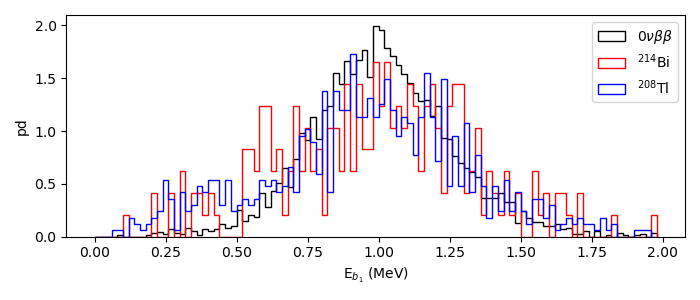

In [74]:
plt.figure(figsize=[7, 3])

bins = np.arange(0, 2.0, 0.02)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.eblob1, bins=bins, density=True, histtype="step", color="k", label=r"$0\nu\beta\beta$")
plt.hist(tracks_214Bi.eblob1, bins=bins, density=True, histtype="step", color="r", label=r"$^{214}$Bi")
plt.hist(tracks_208Tl.eblob1, bins=bins, density=True, histtype="step", color="b", label=r"$^{208}$Tl")

plt.ylabel("pd")
plt.xlabel(r"E$_{b_1}$ (MeV)")
plt.legend()
plt.tight_layout()

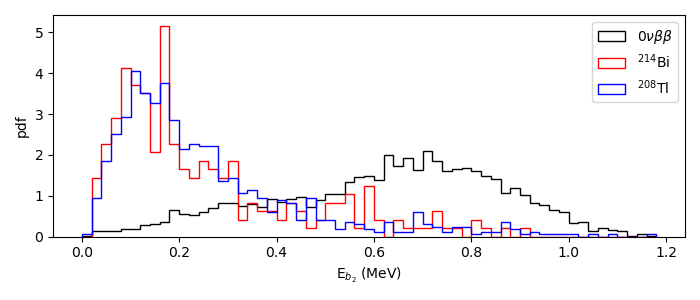

In [75]:
plt.figure(figsize=[7, 3])

bins = np.arange(0, 1.20, 0.02)
binc = (bins[1:] + bins[:-1])/2.

plt.hist(tracks_0nubb.eblob2, bins=bins, density=True, histtype="step", color="k", label=r"$0\nu\beta\beta$")
plt.hist(tracks_214Bi.eblob2, bins=bins, density=True, histtype="step", color="r", label=r"$^{214}$Bi")
plt.hist(tracks_208Tl.eblob2, bins=bins, density=True, histtype="step", color="b", label=r"$^{208}$Tl")

plt.ylabel("pdf")
plt.xlabel(r"E$_{b_2}$ (MeV)")
plt.legend()
plt.tight_layout()

In [101]:
# figure of merit
Eb2 = np.arange(0, 1.2, 0.02)

s = []
b = []

for eb2 in Eb2:
    s.append( np.sum(tracks_0nubb.eblob2>eb2)                                    / Ns)
    b.append((np.sum(tracks_214Bi.eblob2>eb2) + np.sum(tracks_208Tl.eblob2>eb2)) / Nb)
s = np.array(s)
b = np.array(b)

fom = s/np.sqrt(b)
fom[fom == np.inf] = 0

print("            f.o.m max", round(np.max(fom), 2))
print("    Signal efficiency", round(s[np.argmax(fom)], 5))
print("Background efficiency", round(b[np.argmax(fom)], 5))

            f.o.m max 7.32
    Signal efficiency 0.34792
Background efficiency 0.00226


/var/folders/x0/7w5c6z2j3n3dc8rqww2szh200000gn/T/ipykernel_48164/1445988994.py:13: RuntimeWarning: divide by zero encountered in true_divide
  fom = s/np.sqrt(b)


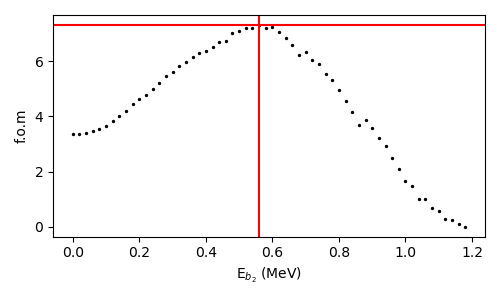

In [102]:
plt.figure(figsize=[5, 3])
plt.scatter(Eb2, fom, s=2, c="k")

plt.axvline(Eb2[np.argmax(fom)], c="r")
plt.axhline(        np.max(fom), c="r")

plt.ylabel("f.o.m")
plt.xlabel(r"E$_{b_2}$ (MeV)")
plt.tight_layout();

In [143]:
df = eff_df.loc[(slice(None), ("208Tl", "214Bi")), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()

print("Background rate (counts/year):", b[np.argmax(fom)]*Nb/T)

Background rate (counts/year): 2.7589804787064427


## $T^{0\nu\beta\beta}_{1/2}$

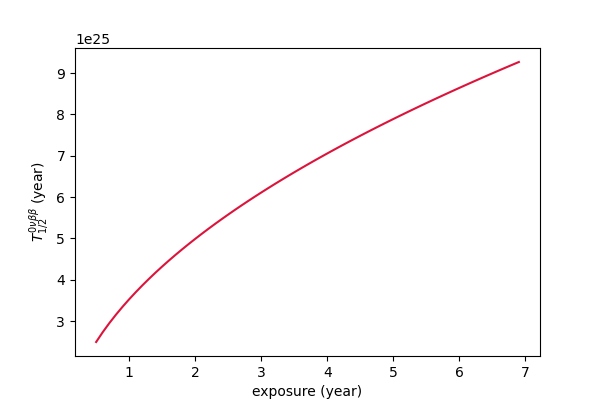

In [138]:
df = eff_df.loc[(slice(None), ("208Tl", "214Bi")), :]
T  = (df.nreco/df.nreco.sum() * df.exposure).sum()
alpha = 1.64 # 90 % CL

t = np.arange(0.5, 7, 0.1)
T12 = np.log(2) * t * np.max(fom) * N0 / (np.sqrt(Nb/T * t) * alpha)

plt.figure(figsize=[6, 4])
plt.plot(t, T12, color="crimson")
plt.xlabel("exposure (year)")
plt.ylabel(r"$T^{0\nu\beta\beta}_{1/2}$ (year)");

In [20]:
# gaussian_fit = False

# if gaussian_fit:
#     mu  = zfit.Parameter( 'mu', 0)
#     sig = zfit.Parameter('sig', 0)

In [21]:
# if gaussian_fit:
#     # gaussian fit
#     emin, emax = 2.44, 2.49
#     obs = zfit.Space('E', (emin, emax))

#     mu.lower = emin
#     mu.upper = emax
#     mu.set_value((emax+emin)/2.)

#     sig.lower = 0
#     sig.upper = emax - emin
#     sig.set_value((emax-emin)/2.)

#     model     = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sig)
#     minimizer = zfit.minimize.Minuit(gradient=True)

In [22]:
# if gaussian_fit:
#     data = tracks_0nubb.energy.values
#     data = data[(emin<=data)& (data<=emax)]

#     nll = zfit.loss.UnbinnedNLL(model, tracks_0nubb.energy.values)

#     result = minimizer.minimize(nll)
#     print(result)

In [19]:
# plt.figure(figsize=[8, 4])

# xlabel = "x_ave"
# ylabel = "energy"

# x = tracks_0nubb.get(xlabel)
# y = tracks_0nubb.get(ylabel)

# xbins = np.linspace(x.min(), x.max(), 100)
# ybins = np.linspace(2.4, y.max(), 100)

# plt.hist2d( x, y, bins=[xbins, ybins])

# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.tight_layout();

In [129]:
# from invisible_cities.reco.corrections import read_maps

# maps = read_maps("/Users/gonzalo/NEXT/DATA/production/LightTables/map_NEXT100_MC.h5")

# plt.figure(figsize=[9, 3])
# plt.subplot(121)
# plt.imshow(maps.e0)

# plt.subplot(122)
# plt.imshow(maps.lt)

# plt.tight_layout()